### Обучение с нуля нейронной сети на текстурных изображениях KTH_TIPS с последующим transfer learning на культурах

In [1]:
import torch
torch.cuda.is_available()

True

#### Обучение с нуля

In [2]:
# import the necessary packages
import torch
import os

# define path to the original dataset and base path to the dataset
# splits
DATA_PATH = "KTH_TIPS"
BASE_PATH = "dataset"

TRAIN = os.path.join(BASE_PATH, "train")
VAL = os.path.join(BASE_PATH, "val")

In [16]:
# specify ImageNet mean and standard deviation and image size
#MEAN = [0.485, 0.456, 0.406]
MEAN = [0.45]
STD = [0.225]
#STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 200
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# specify training hyperparameters
FEATURE_EXTRACTION_BATCH_SIZE = 30
EPOCHS = 10
LR = 0.005

In [4]:
# import the necessary packages
from torch.utils.data import DataLoader
from torchvision import datasets
import os

def get_dataloader(rootDir, transforms, batchSize, shuffle=True):
    # create a dataset and use it to create a data loader
    ds = datasets.ImageFolder(root=rootDir,
        transform=transforms)
    loader = DataLoader(ds, batch_size=batchSize,
        shuffle=shuffle,
        num_workers=os.cpu_count(),
        pin_memory=True if DEVICE == "cuda" else False)
    # return a tuple of  the dataset and the data loader
    return (ds, loader)

In [5]:
from torchvision import transforms

# define augmentation pipelines
trainTansform = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])
valTransform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

In [6]:
(trainDS, trainLoader) = get_dataloader(TRAIN,
    transforms=trainTansform,
    batchSize=FEATURE_EXTRACTION_BATCH_SIZE)

(valDS, valLoader) = get_dataloader(VAL,
    transforms=valTransform,
    batchSize=FEATURE_EXTRACTION_BATCH_SIZE, shuffle=False)

In [7]:
from torchvision.models import resnet18, resnet34
from torch import nn

model = resnet34(weights=None)
#model = resnet34(weights=None)

modelOutputFeats = model.fc.in_features
model.fc = nn.Linear(modelOutputFeats, len(trainDS.classes))
model = model.to(DEVICE)

In [8]:
DEVICE

'cuda'

In [9]:
# initialize loss function and optimizer (notice that we are only
# providing the parameters of the classification top to our optimizer)

lossFunc = nn.CrossEntropyLoss()
#opt = torch.optim.Adam(model.fc.parameters(), lr=LR)
opt = torch.optim.SGD(model.parameters(), lr=LR)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // FEATURE_EXTRACTION_BATCH_SIZE
valSteps = len(valDS) // FEATURE_EXTRACTION_BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "train_acc": [], "val_loss": [],
    "val_acc": []}

[INFO] training the network...


 10%|████████▎                                                                          | 1/10 [00:19<02:56, 19.66s/it]

[INFO] EPOCH: 1/10
Train loss: 0.192222, Train accuracy: 0.9309
Val loss: 2.065733, Val accuracy: 0.8000


 20%|████████████████▌                                                                  | 2/10 [00:40<02:44, 20.57s/it]

[INFO] EPOCH: 2/10
Train loss: 0.217382, Train accuracy: 0.9132
Val loss: 2.048033, Val accuracy: 0.8000


 30%|████████████████████████▉                                                          | 3/10 [01:01<02:25, 20.79s/it]

[INFO] EPOCH: 3/10
Train loss: 0.219865, Train accuracy: 0.9147
Val loss: 1.461285, Val accuracy: 0.8250


 40%|█████████████████████████████████▏                                                 | 4/10 [01:22<02:05, 20.84s/it]

[INFO] EPOCH: 4/10
Train loss: 0.186287, Train accuracy: 0.9250
Val loss: 1.776117, Val accuracy: 0.7250


 50%|█████████████████████████████████████████▌                                         | 5/10 [01:44<01:45, 21.13s/it]

[INFO] EPOCH: 5/10
Train loss: 0.204671, Train accuracy: 0.9279
Val loss: 1.527509, Val accuracy: 0.8250


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [02:09<01:29, 22.37s/it]

[INFO] EPOCH: 6/10
Train loss: 0.173223, Train accuracy: 0.9338
Val loss: 1.074883, Val accuracy: 0.8500


 70%|██████████████████████████████████████████████████████████                         | 7/10 [02:33<01:08, 22.93s/it]

[INFO] EPOCH: 7/10
Train loss: 0.214545, Train accuracy: 0.9147
Val loss: 1.367916, Val accuracy: 0.7750


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [02:58<00:47, 23.53s/it]

[INFO] EPOCH: 8/10
Train loss: 0.175008, Train accuracy: 0.9426
Val loss: 2.993836, Val accuracy: 0.7000


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [03:22<00:23, 23.76s/it]

[INFO] EPOCH: 9/10
Train loss: 0.174664, Train accuracy: 0.9456
Val loss: 1.849945, Val accuracy: 0.7750


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:46<00:00, 22.63s/it]

[INFO] EPOCH: 10/10
Train loss: 0.224140, Train accuracy: 0.9191
Val loss: 1.361874, Val accuracy: 0.8250
[INFO] total time taken to train the model: 226.34s


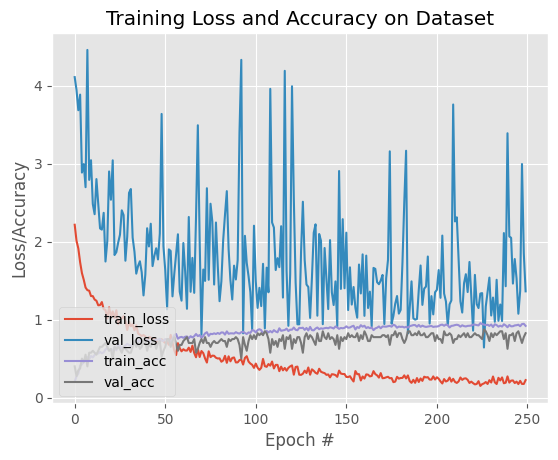

In [17]:
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # initialize the number of correct predictions in the training
    # and validation step
    trainCorrect = 0
    valCorrect = 0
    # loop over the training set
    
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(DEVICE), y.to(DEVICE))
        # perform a forward pass and calculate the training loss
        pred = model(x)
        loss = lossFunc(pred, y)
        # calculate the gradients
        loss.backward()
        
        # check if we are updating the model parameters and if so
        # update them, and zero out the previously accumulated gradients
        if (i + 2) % 2 == 0:
            opt.step()
            opt.zero_grad()
        # add the loss to the total training loss so far and
        # calculate the number of correct predictions
        totalTrainLoss += loss
        trainCorrect += (pred.argmax(1) == y).type(
            torch.float).sum().item()
        
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(DEVICE), y.to(DEVICE))
            # make the predictions and calculate the validation loss
            pred = model(x)
            totalValLoss += lossFunc(pred, y)
            # calculate the number of correct predictions
            valCorrect += (pred.argmax(1) == y).type(
                torch.float).sum().item()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    # calculate the training and validation accuracy
    trainCorrect = trainCorrect / len(trainDS)
    valCorrect = valCorrect / len(valDS)
    # update our training history
    
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["train_acc"].append(trainCorrect)
    H["val_loss"].append(avgValLoss.cpu().detach().numpy())
    H["val_acc"].append(valCorrect)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, EPOCHS))
    print("Train loss: {:.6f}, Train accuracy: {:.4f}".format(
        avgTrainLoss, trainCorrect))
    print("Val loss: {:.6f}, Val accuracy: {:.4f}".format(
        avgValLoss, valCorrect))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
    endTime - startTime))
#plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["val_loss"], label="val_loss")
plt.plot(H["train_acc"], label="train_acc")
plt.plot(H["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [18]:
# serialize the model to disk
torch.save(model, 'results/experiment2/nn_pretrained/nn27')